<a href="https://colab.research.google.com/github/nadgir-praveen/data-science-lab/blob/main/mini_projects/PN_M3_NB_MiniProject_01_MLR_MPI_OpenMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Multiple Linear Regression using MPI and OpenMP

## Learning Objectives

At the end of the mini-project, you will be able to :

* understand the collective communication operations like scatter, gather, broadcast
* understand the blocking and non-blocking communication
* implement multiple linear regression and run it using MPI
* implement the multiple linear regression based predictions using OpenMP

### Dataset

The dataset chosen for this mini-project is [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). The dataset is made up of 9568 records and 5 columns. Each record contains the values for Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output.

Predicting full load electrical power output of a base load power plant is important in order to maximize the profit from the available megawatt hours.  The base load operation of a power plant is influenced by four main parameters, which are used as input variables in the dataset, such as ambient temperature, atmospheric pressure, relative humidity, and exhaust steam pressure. These parameters affect electrical power output, which is considered as the target variable.

**Note:** The data was collected over a six year period (2006-11).

## Information

#### MPI in a Nutshell

MPI stands for "Message Passing Interface". It is a library of functions (in C / Python) or subroutines (in Fortran) that you insert into source code to perform data communication between processes. MPI was developed over two years of discussions led by the MPI Forum, a group of roughly sixty people representing some forty organizations.

To know more about MPI click [here](https://hpc-tutorials.llnl.gov/mpi/)


#### Multiple Linear Regression

Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target or criterion variable). The variables we are using to predict the value of the dependent variable are called the independent variables (or sometimes, the predictor, explanatory or regressor variables).

**Note:** We will be using the mpi4py Python package for MPI based code implementation

## Grading = 20 Points

**Run the below code to install mpi4py package**

In [ ]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746513 sha256=3349c7f57d6fa18acf2b58d1cdc26d9bfb87f09c5d437ff9f0706d3b1fafd069
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


#### Importing Necessary Packages

In [ ]:
# Importing pandas
import pandas as pd
# Importing Numpy
import numpy as np
# Importing MPI from mpi4py package
from mpi4py import MPI
# Importing sqrt function from the Math
from math import sqrt
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time

#### Downloading the data

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv

### Overview

* Load the data and perform data pre-processing
* Identify the features, target and split the data into train and test
* Implement multiple Linear Regression by estimating the coefficients on the given data
* Use MPI package to distribute the data and implement `communicator`
* Define functions for each objective and make a script (.py) file to execute using MPI command
* Use OpenMP component to predict the data and calculate the error on the predicted data
* Implement the Linear Regression from `sklearn` and compare the results

#### Exercise 1: Load data (1 point)

Write a function that takes the filename as input and loads the data in a pandas dataframe with the column names as Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output respectively.

**Hint:** read_csv()


In [ ]:
FILENAME = "/content/PowerPlantData.csv" # File path

# YOUR CODE HERE to Define a function to load the data
def load_data(file_name):
    df = pd.read_csv(file_name)
    return df

In [ ]:
df = load_data(FILENAME)
df.sample(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


#### Exercise 2: Explore data (1 point)

Write a function that takes the data loaded using the above defined function as input and explore it.

**Hint:** You can define and check for following things in the dataset inside a function

- checking for the number of rows and columns
- summary of the dataset
- check for the null values
- check for the duplicate values

In [ ]:
# YOUR CODE HERE
def process(df):
    print(f'data set size is(rows, columns): {df.shape}')
    if df.shape[0] == 0 or df.shape[1] == 0:
        return 'dataframe does not contain any info'
    print('\n data set properties: \n')
    print(df.describe())
    cols_with_nulls = df.columns[df.isnull().any()].tolist()
    if len(cols_with_nulls):
        print('There are columns with null values')
        # handle null values
    cols_with_nans = df.columns[df.isna().any()].tolist()
    if len(cols_with_nans):
        print('There are columns with NAN values')
        # handle NAN values
    # check for duplicates
    if df[df.duplicated()].shape[0] > 1:
        print(f'there are {df[df.duplicated()].shape[0]} duplicate rows, dropping')
        df.drop_duplicates(inplace=True, ignore_index=True)
    return df


In [ ]:
df = load_data(FILENAME)
df = process(df)

data set size is(rows, columns): (9568, 5)

 data set properties: 

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
there are 41 duplicate rows, dropping


#### Exercise 3: Handle missing data (1 point)

After exploring the dataset if there are any null values present in the dataset then define a function that takes data loaded using the above defined function as input and handle the null values accordingly.

**Hint:**

- Drop the records containing the null values - dropna()
- Replace the null values with the mean/median/mode - fillna()

In [ ]:
# Function to handle missing data

# YOUR CODE HERE

#### Exercise 4: Scale the data (1 point)

Write a function that takes the data after handling the missing data as input and returns the standardized data.

**Hint:**

- standardization of the data  can be performed using the below formula

$ (x - mean(x)) / std(x) $

In [ ]:
# Defining a function to standardize the data
# YOUR CODE HERE

def standardize_data(df, cols):
    for c in cols:
        print(f'column: {c}, Mean: {df[c].mean()}, std: {df[c].std()}')
        df[c] = df[c] - df[c].mean()/df[c].std()
    return df


In [ ]:
df = load_data(FILENAME)
df = process(df)
df = standardize_data(df, ['AT', 'V', 'AP', 'RH'])

data set size is(rows, columns): (9568, 5)

 data set properties: 

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
there are 41 duplicate rows, dropping
column: AT, Mean: 19.658225044610052, std: 7.444397078136742
column: V, Mean: 54.29342080403065, std: 12.686309009374435
column: AP, Mean: 1013.2370840768342, std: 5.9405260647572895
column: RH, Mean: 73.33495119135091, std: 14.60751325291208


#### Exercise 5: Feature selection (1 point)

Write a function that takes scaled data as input and returns the features and target variable values

**Hint:**

- Features: AmbientTemperature, ExhaustVaccum, AmbientPressure, RelativeHumidity
- Target Variable: EnergyOutput

In [ ]:
# Define a function
# YOUR CODE HERE

def get_features_target(df):
    return df[['AT', 'V', 'AP', 'RH']].values, df[['PE']].values


In [ ]:
df = load_data(FILENAME)
df = process(df)
df = standardize_data(df, ['AT', 'V', 'AP', 'RH', 'PE'])
features, target = get_features_target(df)

data set size is(rows, columns): (9568, 5)

 data set properties: 

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
there are 41 duplicate rows, dropping
column: AT, Mean: 19.658225044610052, std: 7.444397078136742
column: V, Mean: 54.29342080403065, std: 12.686309009374435
column: AP, Mean: 1013.2370840768342, std: 5.9405260647572895
column: RH, Mean: 73.33495119135091, std: 14.60751325291208
column: PE, 

#### Exercise 6: Correlation (1 point)

Calculate correlation between the variables

          AT         V        AP        RH        PE
AT  1.000000  0.843689 -0.508222 -0.543947 -0.947908
V   0.843689  1.000000 -0.415718 -0.312214 -0.869900
AP -0.508222 -0.415718  1.000000  0.101631  0.518687
RH -0.543947 -0.312214  0.101631  1.000000  0.391175
PE -0.947908 -0.869900  0.518687  0.391175  1.000000


<Axes: >

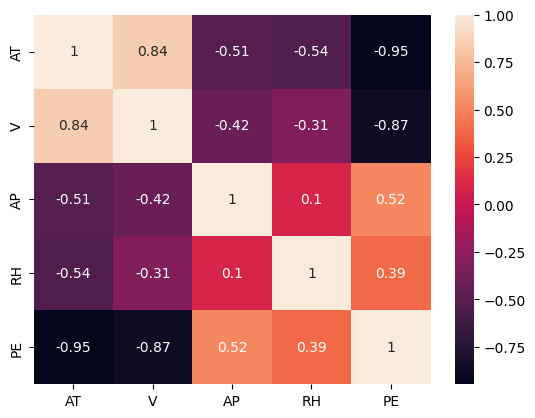

In [ ]:
# YOUR CODE HERE
import seaborn as sns
corr = df.corr()
print(corr)


sns.heatmap(df.corr(), annot=True)

#### Exercise 7: Estimate the coefficients (2 points)

Write a function that takes features and target as input and returns the estimated coefficient values

**Hint:**

- Calculate the estimated coefficients using the below formula

$ β = (X^T X)^{-1} X^T y $

- transpose(), np.linalg.inv()

In [ ]:
# Calculating the coeffients

# YOUR CODE HERE

def coefficients(X, y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)


print(coefficients(features, target))

[[-1.6334648 ]
 [-0.27796428]
 [ 0.56433398]
 [-0.09064591]]


#### Exercise 8: Fit the data to estimate the coefficients (2 points)

Write a function named fit which takes features and targets as input and returns the intercept and coefficient values.

**Hint:**

- create a dummy column in the features dataframe which is made up of all ones
- convert the features dataframe into numpy array
- call the estimated coefficients function which is defined above
- np.ones(), np.concatenate()

In [ ]:
# defining a fit function
def fit(x, y):
    # Add a column of ones to features for the intercept term
    X = np.column_stack((np.ones(len(x)), x))

    # Compute beta using the least squares formula
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    # Extract the intercept and coefficients
    intercept = beta[0]
    coefficients = beta[1:]
    print(f'\n Intercept: {intercept}, \n coeffcients: {coefficients}')
    return intercept, coefficients

In [ ]:
df = load_data(FILENAME)
df = process(df)
df = standardize_data(df, ['AT', 'V', 'AP', 'RH', 'PE'])
features, target = get_features_target(df)
intercept, coeff = fit(features, target)


data set size is(rows, columns): (9568, 5)

 data set properties: 

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
there are 41 duplicate rows, dropping
column: AT, Mean: 19.658225044610052, std: 7.444397078136742
column: V, Mean: 54.29342080403065, std: 12.686309009374435
column: AP, Mean: 1013.2370840768342, std: 5.9405260647572895
column: RH, Mean: 73.33495119135091, std: 14.60751325291208
column: PE, 

#### Exercise 9: Predict the data on estimated coefficients (1 point)

Write a function named predict which takes features, intercept and coefficient values as input and returns the predicted values.

**Hint:**

- Fit the intercept, coefficients values in the below equation

  $y = b_0 + b_1*x + ... + b_i*x_i$

In [ ]:
 # fucntion to predict the values
def predict(x, intercept, coefficients):
    '''
    y = b_0 + b_1*x + ... + b_i*x_i
    '''
    #YOUR CODE HERE
    predictions = intercept+x.dot(coefficients)
    return predictions


In [ ]:
df = load_data(FILENAME)
df = process(df)
df = standardize_data(df, ['AT', 'V', 'AP', 'RH', 'PE'])
features, target = get_features_target(df)
intercept, coeff = fit(features, target)
y_pred = predict(features, intercept, coeff)

data set size is(rows, columns): (9568, 5)

 data set properties: 

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
there are 41 duplicate rows, dropping
column: AT, Mean: 19.658225044610052, std: 7.444397078136742
column: V, Mean: 54.29342080403065, std: 12.686309009374435
column: AP, Mean: 1013.2370840768342, std: 5.9405260647572895
column: RH, Mean: 73.33495119135091, std: 14.60751325291208
column: PE, 

#### Exercise 10: Root mean squared error (1 point)

Write a function to calculate the RMSE error.

**Hint:**

- [How to calculate the RSME error](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)

In [ ]:
# Define a function to calculate the error

# YOUR CODE HERE
def rmse(targets, predictions):
    # Calculate the Root Mean Squared Error (RMSE)
    mse = np.mean((targets - predictions)**2)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
df = load_data(FILENAME)
df = process(df)
df = standardize_data(df, ['AT', 'V', 'AP', 'RH', 'PE'])
features, target = get_features_target(df)
intercept, coeff = fit(features, target)
y_pred = predict(features, intercept, coeff)
rmse_values = rmse(target, y_pred)

print(f'\n average rmse: {rmse_values}')

data set size is(rows, columns): (9568, 5)

 data set properties: 

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
there are 41 duplicate rows, dropping
column: AT, Mean: 19.658225044610052, std: 7.444397078136742
column: V, Mean: 54.29342080403065, std: 12.686309009374435
column: AP, Mean: 1013.2370840768342, std: 5.9405260647572895
column: RH, Mean: 73.33495119135091, std: 14.60751325291208
column: PE, 

#### Exercise 11: Split the data into train and test (1 point)

Write a function named train_test_split which takes features and targets as input and returns the train and test sets respectively.

**Hint:**

- Shuffle the data
- Consider 70 % of data as a train set and the rest of the data as a test set

In [ ]:
# YOUR CODE HERE
def train_test_split(features, targets, test_size=0.3, random_state=None):
    # Set a random seed if specified
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle the indices
    indices = np.arange(len(features))
    np.random.shuffle(indices)

    # Calculate the number of samples for the test set
    test_samples = int(len(features) * test_size)

    # Split the data into training and testing sets
    train_indices = indices[:-test_samples]
    test_indices = indices[-test_samples:]

    train_features = features[train_indices]
    train_targets = targets[train_indices]
    test_features = features[test_indices]
    test_targets = targets[test_indices]

    return train_features, test_features, train_targets, test_targets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

#### Exercise 12: Implement predict using OpenMP (1 point)

Get the predictions for test data and calculate the test error(RMSE) by implementing the OpenMP (pymp)

**Hints:**

* Using the pymp.Parallel implement the predict function (use from above)

* Call the predict function by passing test data as an argument

* calculate the error (RMSE) by comparing the Actual test data and predicted test data

In [ ]:
!pip install pymp-pypi

  Preparing metadata (setup.py) ... done
  Created wheel for pymp-pypi: filename=pymp_pypi-0.5.0-py3-none-any.whl size=10318 sha256=e22268481c5d0520bd704848ca5df3d89d4a8045c2e998a6c2e05e40e5bf211e
  Stored in directory: /root/.cache/pip/wheels/5e/db/4b/4c02f5b91b1abcde14433d1b336ac00a09761383e7bb1013cf
Successfully built pymp-pypi


In [ ]:
import pymp
# YOUR CODE HERE
def parallel_predict(features, intercept, coefficients):
    # Initialize a shared array to store the predicted values
    predicted_values = pymp.shared.array(len(features), dtype='float64')
    # Use pymp.Parallel for parallel execution
    with pymp.Parallel() as p:
        for i in p.range(len(features)):
            predicted_values[i] = predict(features[i], intercept, coefficients)

    return predicted_values

In [ ]:
def parallel_rmse(y_true, y_pred):
  squared_errors = pymp.shared.array(len(y_true), dtype='float64')

  with pymp.Parallel() as p2:
    for i in p2.range(len(y_true)):
      squared_errors[i] = (y_true[i] - y_pred[i]) ** 2

  mean_squared_error = np.mean(squared_errors)
  rmse = np.sqrt(mean_squared_error)
  return rmse

In [ ]:
df = load_data(FILENAME)
df = process(df)
df = standardize_data(df, ['AT', 'V', 'AP', 'RH', 'PE'])
features, target = get_features_target(df)
intercept, coeff = fit(features, target)
y_pred = predict(features, intercept, coeff)
rmse_values = rmse(target, y_pred)
print(f'\n average rmse: {rmse_values}')

y_pred_parallel = parallel_predict(features, intercept, coeff)
rmse_values_parallel = parallel_rmse(target, y_pred_parallel)
print(f'\n average rmse - with parallel : {rmse_values_parallel}')

data set size is(rows, columns): (9568, 5)

 data set properties: 

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
there are 41 duplicate rows, dropping
column: AT, Mean: 19.658225044610052, std: 7.444397078136742
column: V, Mean: 54.29342080403065, std: 12.686309009374435
column: AP, Mean: 1013.2370840768342, std: 5.9405260647572895
column: RH, Mean: 73.33495119135091, std: 14.60751325291208
column: PE, 

<ipython-input-24-71cb9daf4dd6>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_values[i] = predict(features[i], intercept, coefficients)
<ipython-input-24-71cb9daf4dd6>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_values[i] = predict(features[i], intercept, coefficients)
<ipython-input-25-5a5b932d6827>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  squared_errors[i] = (y_true[i] - y_pred[i]) ** 2
<ipython-input-25-5a5b932d6827>:6: Depr


 average rmse - with parallel : 4.558387548061048


#### Exercise 13: Create a communicator (1 point)

Create a comunicator and define the rank and size

In [ ]:
# YOUR CODE HERE

#### Exercise 14: Divide the data into slices (1 point)

Write a function named dividing_data which takes train features set, train target set, and size of workers as inputs and returns the sliced data for each worker.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/MiniProject_MPI_DataSlice.JPG)

For Example, if there are 4 processes, slice the data into 4 equal parts with 25% ratio

**Hint:**

- Divide the Data equally among the workers
  - Create an empty list
  - Iterate over the size of workers
  - Append each slice of data to the list

In [ ]:
def dividing_data(x_train, y_train, size_of_workers):
    # Size of the slice
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    # YOUR CODE HERE

#### Exercise 15: Prepare the data in root worker to assign data for all the workers (1 point)

- When it is the root worker, perform the below operation:
    - Store the features and target values in separate variables
    - Split the data into train and test sets using the train_test_split function defined above
    - Divide the data among the workers using the dividing_data function above

In [ ]:
# YOUR CODE HERE

#### Exercise 16: Scatter and gather the data (1 point)

Perform the below operations:

- Send slices of the training set(the features data X and the expected target data Y) to every worker including the root worker
    - **Hint:** scatter()
    - use `barrier()` to block workers until all workers in the group reach a Barrier, to scatter from root worker.
- Every worker should get the predicted target Y(yhat) for each slice
- Get the new coefficient of each instance in a slice
    - **Hint:** fit function defined above
- Gather the new coefficient from each worker
    - **Hint:** gather()
    - Take the mean of the gathered coefficients
- Calculate the root mean square error for the test set

To know more about `scatter`, `gather` and `barrier` click [here](https://nyu-cds.github.io/python-mpi/05-collectives/)

In [ ]:
# YOUR CODE HERE

#### Exercise 17: Make a script and execute everything in one place (1 point)

Write a script(.py) file which contains the code of all the above exercises in it so that you can run the code on multiple processes using MPI.

**Hint:**

- magic commands
- put MPI related code under main function
- !mpirun --allow-run-as-root -np 4 python filename.py

In [ ]:
# YOUR CODE HERE for scipt(.py)

In [ ]:
# YOUR CODE HERE for MPI command

#### Exercise 18: Use Sklearn to compare (1 point)

Apply the Linear regression on the given data using sklearn package and compare with the above results

**Hint:**
* Split the data into train and test
* Fit the train data and predict the test data using `sklearn Linear Regression`
* Compare the coefficients and intercept with above estimated coefficients
* calculate loss (RMSE) on test data and predictions and compare

In [ ]:
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.30)

regr = LinearRegression()
regr.fit(X_train, y_train)

y_predict = regr.predict(X_test)
rmse = mean_squared_error(y_true=y_test,y_pred=y_predict,squared=False)

print(rmse)

4.571854398544851
